In [57]:
%cd /Users/sophiatonelli/library_script/script

import os
os.chdir('/Users/sophiatonelli/library_script/script/work')


import os, sys # to communicate with the machine you are operating
sys.path.append(os.getcwd()) #  to search python modules from the current path. This helps us to use SCRIPT modules.
from __future__ import print_function # Force python2 to generate same output as python3 when using print function
import numpy as np # for doing numerical calcuations
import matplotlib.pyplot as plt # for making and displaying plots
import script # for using SCRIPT functionalities
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 11})# increase fontsize of text on plots

/Users/sophiatonelli/library_script/script


scp -r /Users/sophiatonelli/library_script/script ssh-sotonelli@rigel.mpia.de:/data/beegfs/astro-storage/groups/davies/ssh-sotonelli

In [58]:
gadget_snap = '/Users/sophiatonelli/Downloads/snap_140' #import data file 
#'/Users/sophiatonelli/Downloads/snap_120' 
outpath = '/Users/sophiatonelli/library_script/script/work/script_files' #./script_files' # the generated density and velocity fields will be saved in script_files/
scaledist = 1e-3 # sets the scale for box size. 1e-3 for box of length in kpc/h and 1. for length in cMpc/h

default_simulation_data = script.default_simulation_data(gadget_snap, outpath, sigma_8=0.829, ns=0.961, omega_b=0.0482, scaledist=scaledist) # Read binary data 

In [59]:
print("Simulation box size:", default_simulation_data.box, "cMpc/h") #box size in cMpc/h
print("Simulation redshift:", default_simulation_data.z) #redshift of the simulation
print("Simulation box size in Mpc/h:", default_simulation_data.box * 1e-3) #box size in Mpc/h


Simulation box size: 256.0 cMpc/h
Simulation redshift: 6.0
Simulation box size in Mpc/h: 0.256


In [60]:
#define RESOLUTION, number of cells to which density fields are smoothened (i.e. resolution 256/128 cMpc/h)
ngrid = 128  

matter_fields = script.matter_fields(default_simulation_data, ngrid, outpath, overwrite_files=False) 

In [ ]:
import numpy as np
from scipy.optimize import brentq

list_xhi_vals = [0.2, 0.5, 0.7]      #target mean neutral fractions
list_log10Mmin_vals = [8.0, 9.0, 10.0]  #log10(Mmin)

zeta_vals = []  #store all (Mmin, xhi) pairs

for log10Mmin in list_log10Mmin_vals:
    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    fcoll_mean = fcoll_arr.mean()
    print(f"\nlog10(Mmin): {log10Mmin:.1f}  fcoll mean: {fcoll_mean:.4f}")

    for target_xhi in list_xhi_vals:
        #target xhi mean value adjusted for density contrast
        
        #define the function for brentq whose root we want: f(zeta) = desired xhi - actual xhi
        def f(zeta):
            ionization_map = script.ionization_map(matter_fields)
            qi_arr = ionization_map.get_qi(zeta * fcoll_arr)
            xhi = (1 - qi_arr)*(1 + matter_fields.densitycontr_arr)
            xhi_mean = xhi.mean()
            return xhi_mean - target_xhi

        try:
            #use brentq to find root in a sensible interval (adjust if needed)
            zeta_root = brentq(f, 1, 500) #BRENTQ method to find root of f(zeta) = 0
            zeta_vals.append(zeta_root)
            print(f"✅ Found zeta: {zeta_root:.3f} for log10Mmin: {log10Mmin:.1f} and target xhi: {target_xhi}")

        except ValueError:
            print(f"❌ No root found for log10Mmin: {log10Mmin:.1f} and target xhi: {target_xhi}")
            zeta_vals.append(None)

print("\nAll zeta values (should be 9):", zeta_vals)


In [61]:
#second method to find zeta
zeta_vals2 = []  #store all (Mmin, xhi) pairs


list_xhi_vals = [0.2, 0.5, 0.7]      #target mean neutral fractions
list_log10Mmin_vals = [8.0, 9.0, 10.0]  #log10(Mmin)


for log10Mmin in list_log10Mmin_vals:
    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    fcoll_mean = fcoll_arr.mean()
    print(f"\nlog10(Mmin): {log10Mmin:.1f}  fcoll mean: {fcoll_mean:.4f}")

    for target_xhi in list_xhi_vals:
        #PHOTON CONSERVATION METHOD
        #ionization mean: <x_HII> = <qi(1+delta)> = <1 - target_xhi> == < zeta * fcoll(1+delta)> --> thus: zeta = (1 - target_xhi) / fcoll_mean where fcoll_mean= <fcoll(1+delta)>
        ionization_map = script.ionization_map(matter_fields)
        qi_arr = ionization_map.get_qi(fcoll_arr)

        delta= matter_fields.densitycontr_arr
        mean_qi = np.mean(qi_arr * (1 + delta))
        fcoll_mean = np.mean(fcoll_arr * (1 + delta))
        zeta_root2 = (1 - target_xhi) / fcoll_mean
        zeta_vals2.append(zeta_root2)
        try:
            print(f"✅ Found zeta: {zeta_root2:.3f} for log10Mmin: {log10Mmin:.1f} and target xhi: {target_xhi}")

        except ValueError:
            print(f"❌ No root found for log10Mmin: {log10Mmin:.1f} and target xhi: {target_xhi}")
            zeta_vals2.append(None)

print("\nAll zeta values (should be 9):", zeta_vals2)



log10(Mmin): 8.0  fcoll mean: 0.0849
✅ Found zeta: 7.393 for log10Mmin: 8.0 and target xhi: 0.2
✅ Found zeta: 4.621 for log10Mmin: 8.0 and target xhi: 0.5
✅ Found zeta: 2.773 for log10Mmin: 8.0 and target xhi: 0.7

log10(Mmin): 9.0  fcoll mean: 0.0427
✅ Found zeta: 13.494 for log10Mmin: 9.0 and target xhi: 0.2
✅ Found zeta: 8.434 for log10Mmin: 9.0 and target xhi: 0.5
✅ Found zeta: 5.060 for log10Mmin: 9.0 and target xhi: 0.7

log10(Mmin): 10.0  fcoll mean: 0.0134
✅ Found zeta: 37.057 for log10Mmin: 10.0 and target xhi: 0.2
✅ Found zeta: 23.160 for log10Mmin: 10.0 and target xhi: 0.5
✅ Found zeta: 13.896 for log10Mmin: 10.0 and target xhi: 0.7

All zeta values (should be 9): [7.393353966255615, 4.620846228909759, 2.772507737345856, 13.493824764055772, 8.433640477534857, 5.060184286520915, 37.05654471447564, 23.160340446547274, 13.896204267928367]


In [ ]:
#reshape into 2D: rows = Mmin, cols = xhi
zeta_array = np.array(zeta_vals2).reshape(len(list_log10Mmin_vals), len(list_xhi_vals)) #do 3 rows and 3 columns reshape
print("Zeta array shape:", zeta_array.shape)
print("Zeta array:\n", zeta_array)

#plot: for each xhi, plot zeta vs log10Mmin
plt.figure(figsize=(8, 6))

for j, target_xhi in enumerate(list_xhi_vals):
    plt.plot(list_log10Mmin_vals, zeta_array[:, j], marker='o', label=f'xHI = {target_xhi}')

plt.xlabel(r'$\log_{10}(M_{\mathrm{min}})$', fontsize=16)
plt.ylabel(r'$\zeta$',fontsize=16)
plt.xticks(list_log10Mmin_vals)  #set x-ticks to match Mmin values
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title(r'$\zeta$ vs. $\log_{10}(M_{\mathrm{min}})$ for Different Neutral Hydrogen Fractions', fontsize=16, pad=15)
plt.legend()
plt.tight_layout()
#plt.savefig('/Users/sophiatonelli/Desktop/pngs_mpia/week3_script_combinations/trend_zeta_vs_Mmin_xhi_redshift6.png', dpi=300)  #save the figure
plt.show()


In [ ]:
nrows, ncols = 3, 3  # 3 log10Mmin, 3 zeta per log10Mmin
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

for j in range(9):
    i = j // 3         # which log10Mmin (row)
    k = j % 3          # which zeta within that Mmin group (column)
    
    log10Mmin = list_log10Mmin_vals[i]
    zeta = zeta_vals2[j]
    neutral_fraction = list_xhi_vals[k]

    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    print("log10(Mmin):", log10Mmin, "fcoll:", fcoll_arr.mean())
    print("zeta:", zeta)

    ionization_map = script.ionization_map(matter_fields)
    qi_arr = ionization_map.get_qi(zeta * fcoll_arr)
    print("qi_arr mean:", qi_arr.mean())

    ax = axes[i, k]  # correct subplot position

    im = ax.imshow(
        1 - qi_arr[:, :, 16],
        extent=[0, default_simulation_data.box, 0, default_simulation_data.box],
        cmap='viridis'
    )
    ax.set_title(rf"$\log_{{10}}(M_{{min}})={log10Mmin},\ \zeta={zeta:.2f}$",
                 fontsize=14,
                 pad=14)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.text(
        0.5, -0.05,
        f"$\\langle x_{{\\mathrm{{HI}}}} \\rangle = {neutral_fraction:.2f}$",
        fontsize=12,
        ha='center',
        va='top',
        transform=ax.transAxes
    )

#common z-redshift label
fig.text(
    0.5, -0.02, rf'$z={default_simulation_data.z:.1f}$',
    fontsize=16,
    ha='center',
    va='top'
)


cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, pad=0.02,
                    label=r'$x_{\mathrm{HI}}$', orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$x_{\mathrm{HI}}$', fontsize=18, labelpad=12)
#plt.savefig('/Users/sophiatonelli/Desktop/pngs_mpia/week3_script_combinations/zeta_vs_Mmin_xhi_maps_redshift6.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import math
import scipy.ndimage
import matplotlib.pyplot as plt

# === Your helper functions here ===
def apply_periodic_index(idx, ngrid): #periodic boundary conditions for DISCRETE integer grid indices. if idx = -1 or ngrid + 2, wraps it back inside [0, ngrid-1].
    return idx % ngrid #12 % 10 = 2	Index wraps around: cell 12 → cell 2; 9 % 10 = 9	still inside box
#a%b: % is the modulo operator, which gives the REMAINDER when a is divided by b.... 10%3 = 10/3=3 (3x3=9) and remainder is 1, so 10%3 = 1.

def apply_periodic_pos(pos, ngrid): #periodic boundary conditions to CONTINUOUS positions in grid units. if pos = [ngrid + 0.5], wraps to [0.5].
    return np.mod(pos, ngrid) #10.3	mod = 0.3 -> 10.3 wraps to 0.3
#np.mod: for each number in pos (i.e. 10.3), compute its remainder after dividing by ngrid (i.e.@pos 200 th-cell % 128 grid cells ).

def choose_random_direction(): 
    theta = np.arccos(np.random.uniform(-1, 1))
    phi = np.random.uniform(0, 2 * np.pi)
    return np.array([np.sin(theta) * np.cos(phi),
                     np.sin(theta) * np.sin(phi),
                     np.cos(theta)], dtype=np.float64)

#def launching_rays(ray_centre_location, random_direction_vector, ionized_mask, max_step_size, step_size=0.05, max_steps = 1000): 
def launching_rays(ray_centre_location, random_direction_vector, ionized_mask, ngrid, cell_size, max_step_size, step_size=0.05, max_steps=1000):
    pos = np.array(ray_centre_location, dtype=np.float64)
    for _ in range(max_steps):
        pos += random_direction_vector * step_size
        pos = apply_periodic_pos(pos, ngrid) #continuity position boundary condition
        idx = np.floor(pos).astype(int) #discrete index boundary condition (associated index cell for vector-position travelled)
        idx = apply_periodic_index(idx, ngrid)
        if not ionized_mask[tuple(idx)]:
            return step_size * _ * cell_size #0.05 x ith x 2cMpc/h = total distance travelled
    return max_step_size #step_size * max_steps * cell_size #if it never hits a neutral regions, it means fully ionized, then take the full box size

#main 
nrows, ncols = 3, 3  # 3 log10Mmin, 3 zeta per Mmin
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), constrained_layout=True)

mean_mfp_list = []  #store means for summary table
var_mfp_list = []   #store variances for summary table
peak_mfp_list = []

for j in range(9):
    i = j // 3  #which log10Mmin (row)
    k = j % 3   #which zeta in this row (column)

    log10Mmin = list_log10Mmin_vals[i]
    zeta = zeta_vals2[j]
    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)

    print(f"Processing log10(Mmin)={log10Mmin}, zeta={zeta:.2f}")

    ionization_map = script.ionization_map(matter_fields)
    qi_arr = ionization_map.get_qi(zeta * fcoll_arr)

    ionized_mask = (qi_arr > 0.5)
    ngrid = qi_arr.shape[0]
    box_size = default_simulation_data.box
    cell_size = box_size / ngrid

    mean_free_paths = []
    peak_mfp_plot = []
    ionized_coords = np.argwhere(ionized_mask)
    num_iterations = 10000

    for _ in range(num_iterations):
        if len(ionized_coords) == 0:
            break
        ray_centre_idx = ionized_coords[np.random.choice(len(ionized_coords))]
        direction = choose_random_direction()
        mfp = launching_rays(ray_centre_idx, direction, ionized_mask, ngrid, cell_size, box_size)
        mean_free_paths.append(mfp)

    mfp_array = np.array(mean_free_paths)
    mean_mfp = np.mean(mfp_array)
    var_mfp = np.var(mfp_array)
    mean_mfp_list.append(mean_mfp)
    var_mfp_list.append(var_mfp)

    counts, bin_edges = np.histogram(mfp_array, bins=20, density=False)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    r_times_dN_dR = bin_centers * counts / bin_widths

    peak_mfp = bin_centers[np.argmax(r_times_dN_dR)]
    peak_mfp_plot.append(peak_mfp)
    peak_mfp_list.append(peak_mfp)
    print(f" Peak MFP: {peak_mfp:.2f}")
    
    
    ax = axes[i, k]
    ax.plot(bin_centers, r_times_dN_dR, drawstyle='steps-mid', color='green')
    ax.axvline(peak_mfp, color='red', linestyle='--', label=rf"$R_{{\rm peak}} = {np.ceil(peak_mfp):.2f}$")
    ax.legend(fontsize=12, loc='upper right')

    #mean, peak and variance
    ax.set_title("\n" +
        rf"$\log_{{10}}(M_{{\min}})={log10Mmin:.1f}, \ \zeta={zeta:.2f}$"
        + "\n"
        + rf"$\langle \rm R \rangle = {mean_mfp:.2f}$, "
        + rf"$\sigma^2 = {var_mfp:.2f}$",
        fontsize=14, pad=10
    )
    
    ax.set_xlabel("R (cMpc/h)", fontsize=14)
    ax.set_ylabel(r"$R\,dN/dR$", fontsize=14)
    #ax.set_xlim(0, box_size * 1.1)
    #ax.set_xscale('log')
    ax.tick_params(labelsize=14)

#plt.savefig('/Users/sophiatonelli/Desktop/pngs_mpia/week3_script_combinations/bsd_combinations_redshift8.png', dpi=300, bbox_inches='tight')
plt.show()

#print summary table
print("\n=== MFP Summary ===")
for idx in range(9):
    print(f"Panel {idx+1}: mean = {mean_mfp_list[idx]:.2f}, variance = {var_mfp_list[idx]:.2f}, peak = {peak_mfp_list[idx]:.2f} (cMpc/h)")


log10(Mmin): 8.0 fcoll: 0.084859654
zeta: 7.393353966255615
qi_arr mean: 0.726425
log10(Mmin): 8.0 fcoll: 0.084859654
zeta: 4.620846228909759
qi_arr mean: 0.40383375
log10(Mmin): 8.0 fcoll: 0.084859654
zeta: 2.772507737345856
qi_arr mean: 0.23555793
log10(Mmin): 9.0 fcoll: 0.042676568
zeta: 13.493824764055772
qi_arr mean: 0.7301099
log10(Mmin): 9.0 fcoll: 0.042676568
zeta: 8.433640477534857
qi_arr mean: 0.3939989
log10(Mmin): 9.0 fcoll: 0.042676568
zeta: 5.060184286520915
qi_arr mean: 0.21951306
log10(Mmin): 10.0 fcoll: 0.013390026
zeta: 37.05654471447564
qi_arr mean: 0.7399809
log10(Mmin): 10.0 fcoll: 0.013390026
zeta: 23.160340446547274
qi_arr mean: 0.39608827
log10(Mmin): 10.0 fcoll: 0.013390026
zeta: 13.896204267928367
qi_arr mean: 0.20797646


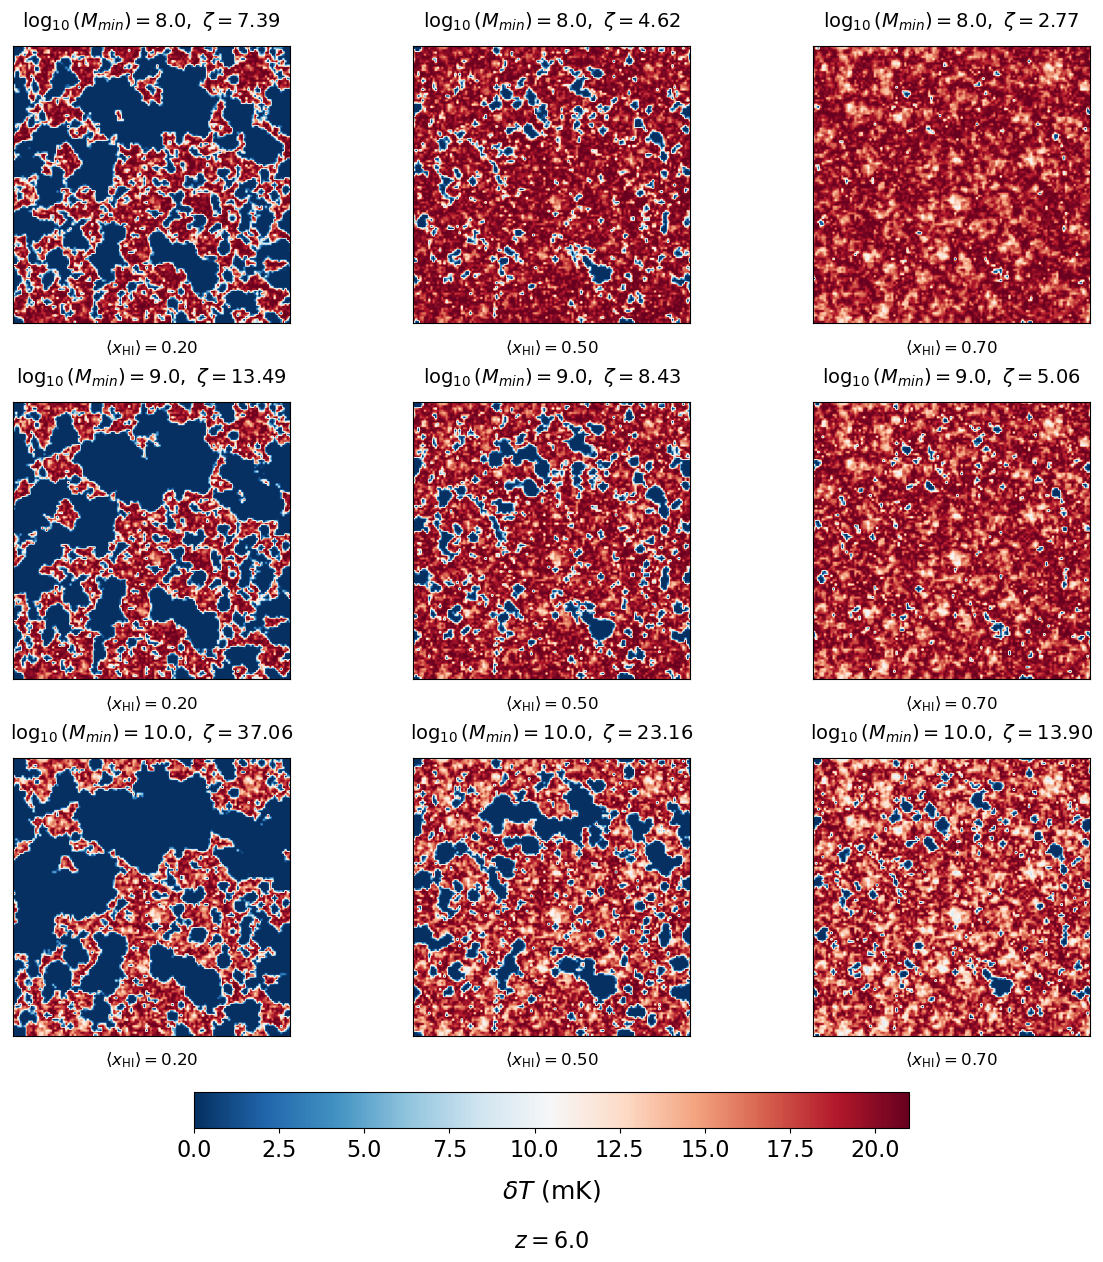

In [ ]:
omega_b = 0.0482 #fractional densities
omega_m = 0.308
h = 0.678  
omega_b_h2= omega_b * h**2  #convert to h^2 units. physical densities for mK
omega_m_h2 = omega_m * h**2
z=default_simulation_data.z #redshift of the simulation
     

nrows, ncols = 3, 3  # 3 log10Mmin, 3 zeta per log10Mmin
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

for j in range(9):
    i = j // 3         # which log10Mmin (row)
    k = j % 3          # which zeta within that Mmin group (column)
    
    log10Mmin = list_log10Mmin_vals[i]
    zeta = zeta_vals2[j]
    neutral_fraction = list_xhi_vals[k]

    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    print("log10(Mmin):", log10Mmin, "fcoll:", fcoll_arr.mean())
    print("zeta:", zeta)

    ionization_map = script.ionization_map(matter_fields)
    qi_arr = ionization_map.get_qi(zeta * fcoll_arr)
    print("qi_arr mean:", qi_arr.mean())
    
    T0 = 27 *  ((1 + z) / 10)**0.5 * ((0.15 / (omega_m_h2))**0.5 *(omega_b_h2 / 0.023)) #compute T0 from theory Furlanetto+2006 T0= T_S - T_CMB (built into T0).
    Delta_HI_arr = (1 - qi_arr) * (1 + matter_fields.densitycontr_arr) #compute neutral hydrogen overdensity 
    dT = T0 * Delta_HI_arr #brightness temperature cube δT = T0 ×(1−qi)×(1+δ)
    dT_subtracted = dT #- np.mean(dT) #fluctuations in the brightness temperature relative to the CMB
    #observable is the fluctuation field because interferometers can’t detect the mean sky brightness at each frequency.   

    ax = axes[i, k]  # correct subplot position

    im = ax.imshow(
        dT_subtracted[:, :, 16],
        extent=[0, default_simulation_data.box, 0, default_simulation_data.box],
        cmap='RdBu_r' 
    )
    ax.set_title(rf"$\log_{{10}}(M_{{min}})={log10Mmin},\ \zeta={zeta:.2f}$",
                 fontsize=14,
                 pad=14)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.text(
        0.5, -0.05,
        f"$\\langle x_{{\\mathrm{{HI}}}} \\rangle = {neutral_fraction:.2f}$", #1 - qi_arr.mean()
        fontsize=12,
        ha='center',
        va='top',
        transform=ax.transAxes
    )

#common z-redshift label
fig.text(
    0.5, -0.02, rf'$z={default_simulation_data.z:.1f}$',
    fontsize=16,
    ha='center',
    va='top'
)


cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, pad=0.02,
                    label='mK', orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$\delta T$ (mK)', fontsize=18, labelpad=12)
#plt.savefig('/Users/sophiatonelli/Desktop/pngs_mpia/week3_script_combinations/temperature_maps_redshift6.png', dpi=300, bbox_inches='tight')
plt.show()

https://ned.ipac.caltech.edu/level5/March14/Zaroubi/Zaroubi4.html

For H₂ clouds: The spin temperature being very low means negligible 21-cm emission..... these clouds are “dark” in the 21-cm line, so we detect them using CO or dust instead.
For H I clouds: The 21-cm line is bright and lets us map neutral hydrogen across galaxies.